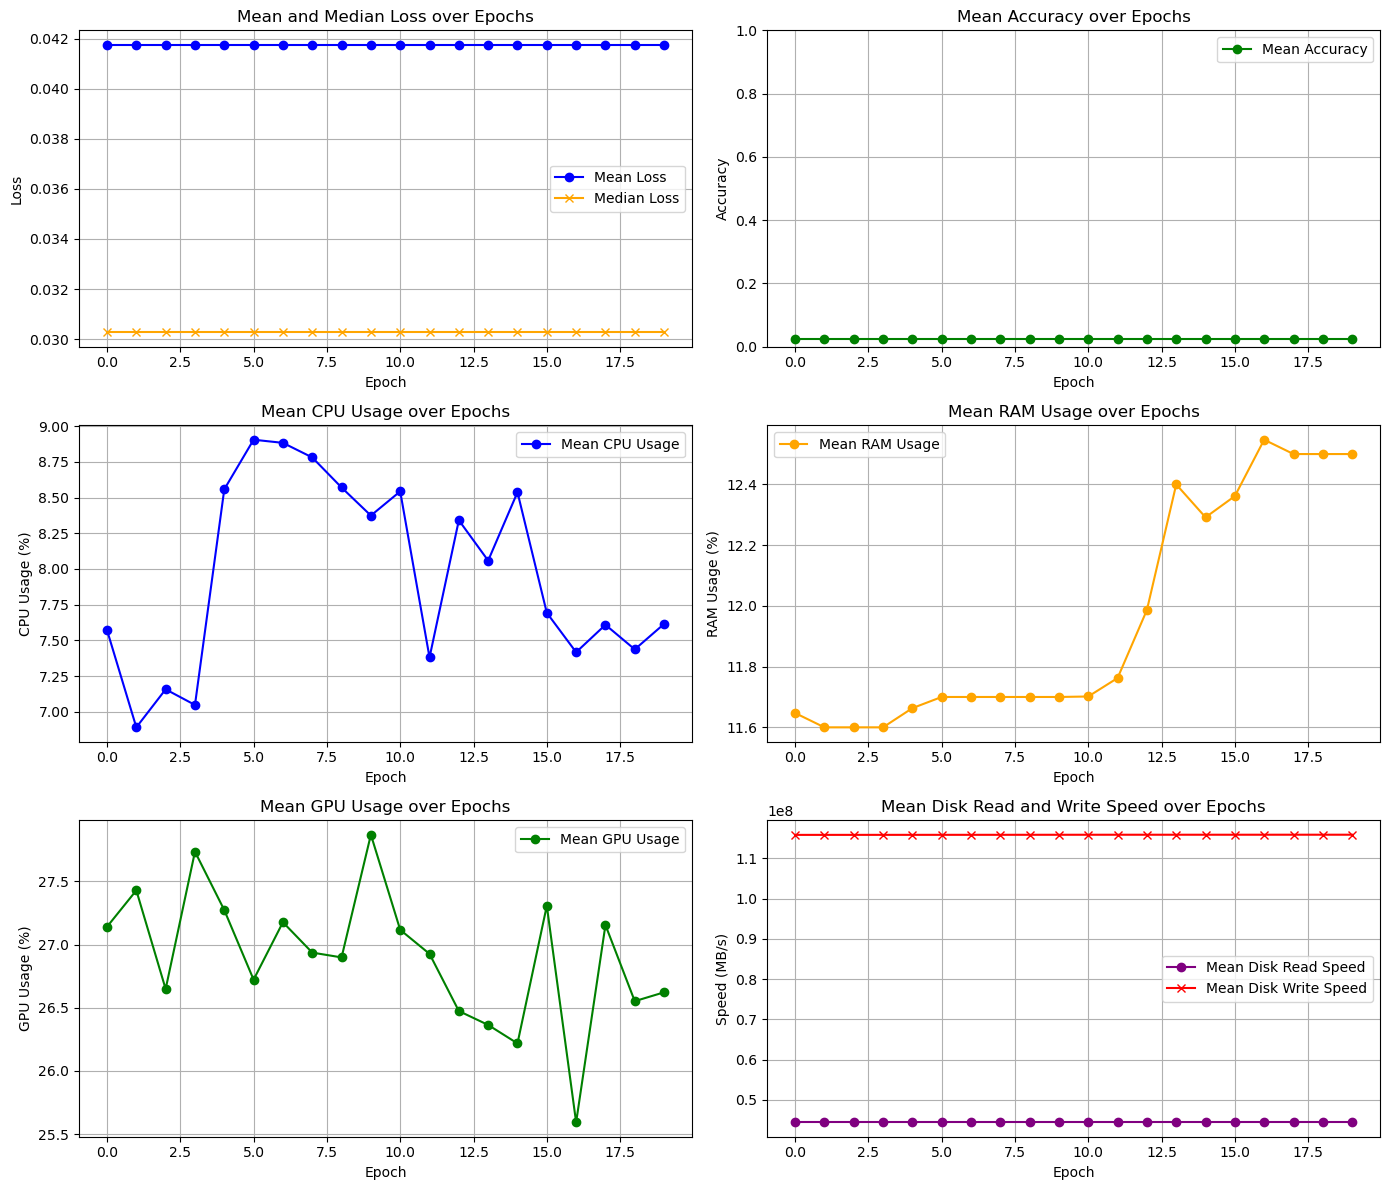

In [29]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Directory containing the log files and the CSV file path (update as needed)
log_dir = r'D:\LLM-CCA testing\test data\5000BBR'
csv_file_path = r'C:\Users\10111\Desktop\SIT724\Runpod\experiment data\通过脚本或取得prague和cubic的数据\cubic & bbr & prague\bbr_output_rtt_cwnd_throughput.csv'

# Step 1: Read the CSV file to get the min and max CWND values for normalization
df_csv = pd.read_csv(csv_file_path)
max_cwnd_value = df_csv['cwnd'].max()
min_cwnd_value = df_csv['cwnd'].min()

# Function to inverse normalize CWND values
def inverse_normalize(normalized_value, min_value, max_value):
    return normalized_value * (max_value - min_value) + min_value

# Function to flatten nested lists
def flatten_list(nested_list):
    """Flattens a nested list to a single level."""
    flat_list = []
    for item in nested_list:
        if isinstance(item, list):
            flat_list.extend(flatten_list(item))
        else:
            flat_list.append(item)
    return flat_list

# Step 2: Load epoch data from JSON files
def load_epoch_data(log_dir):
    log_files = [f for f in os.listdir(log_dir) if f.startswith('custom_logs_epoch_test_') and f.endswith('.json')]
    log_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

    epoch_data = []
    for log_file in log_files:
        epoch_number = int(log_file.split('_')[-1].split('.')[0])
        with open(os.path.join(log_dir, log_file), 'r') as file:
            data = json.load(file)
            epoch_data.append((epoch_number, data['steps']))
    return epoch_data

# Step 3: Calculate metrics
def calculate_metrics(steps, min_cwnd_value, max_cwnd_value):
    losses = [step['test_loss'] for step in steps]
    mean_loss = np.mean(losses)
    median_loss = np.median(losses)

    actions_preds = [flatten_list(step['actions_pred']) for step in steps]
    actions = [flatten_list(step['actions']) for step in steps]

    accuracies = []
    for preds, true_actions in zip(actions_preds, actions):
        preds_array = np.array([inverse_normalize(p, min_cwnd_value, max_cwnd_value) for p in preds])
        true_actions_array = np.array([inverse_normalize(t, min_cwnd_value, max_cwnd_value) for t in true_actions])
        relative_error = np.abs(preds_array - true_actions_array) / np.abs(true_actions_array)
        accuracy = np.mean(relative_error < 0.05)  # Allowable relative error is 5%
        accuracies.append(accuracy)

    mean_accuracy = np.mean(accuracies) if accuracies else None

    # Resource usage metrics
    cpu_usages = [step['CPU Usage'] for step in steps]
    ram_usages = [step['RAM Usage'] for step in steps]
    gpu_usages = [(step['GPU1 Usage'] + step.get('GPU2 Usage', 0)) / 2 for step in steps]
    vram_usages = [(step['VRAM1 Usage'] + step.get('VRAM2 Usage', 0)) / 2 for step in steps]
    disk_read_speeds = [step['Disk Read Speed (MB/s)'] for step in steps]
    disk_write_speeds = [step['Disk Write Speed (MB/s)'] for step in steps]

    return mean_loss, median_loss, mean_accuracy, np.mean(cpu_usages), np.mean(ram_usages), np.mean(gpu_usages), np.mean(vram_usages), np.mean(disk_read_speeds), np.mean(disk_write_speeds)

# Step 4: Load the data and compute the metrics
epoch_data = load_epoch_data(log_dir)

metrics_data = {
    'Epoch': [],
    'Mean Loss': [],
    'Median Loss': [],
    'Mean Accuracy': [],
    'Mean CPU Usage': [],
    'Mean RAM Usage': [],
    'Mean GPU Usage': [],
    'Mean VRAM Usage': [],
    'Mean Disk Read Speed': [],
    'Mean Disk Write Speed': [],
}

for epoch_number, steps in epoch_data:
    mean_loss, median_loss, mean_accuracy, mean_cpu, mean_ram, mean_gpu, mean_vram, mean_read_speed, mean_write_speed = calculate_metrics(steps, min_cwnd_value, max_cwnd_value)
    metrics_data['Epoch'].append(epoch_number)
    metrics_data['Mean Loss'].append(mean_loss)
    metrics_data['Median Loss'].append(median_loss)
    metrics_data['Mean Accuracy'].append(mean_accuracy)
    metrics_data['Mean CPU Usage'].append(mean_cpu)
    metrics_data['Mean RAM Usage'].append(mean_ram)
    metrics_data['Mean GPU Usage'].append(mean_gpu)
    metrics_data['Mean VRAM Usage'].append(mean_vram)
    metrics_data['Mean Disk Read Speed'].append(mean_read_speed)
    metrics_data['Mean Disk Write Speed'].append(mean_write_speed)

# Step 5: Create a DataFrame for plotting
df = pd.DataFrame(metrics_data)

# Plotting the metrics
plt.figure(figsize=(14, 12))

# Plot Mean Loss and Accuracy
plt.subplot(3, 2, 1)
plt.plot(df['Epoch'], df['Mean Loss'], marker='o', label='Mean Loss', color='blue')
plt.plot(df['Epoch'], df['Median Loss'], marker='x', label='Median Loss', color='orange')
plt.title('Mean and Median Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(3, 2, 2)
plt.plot(df['Epoch'], df['Mean Accuracy'], marker='o', label='Mean Accuracy', color='green')
plt.title('Mean Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1
plt.legend()
plt.grid()

# Plot Resource Usages
plt.subplot(3, 2, 3)
plt.plot(df['Epoch'], df['Mean CPU Usage'], marker='o', label='Mean CPU Usage', color='blue')
plt.title('Mean CPU Usage over Epochs')
plt.xlabel('Epoch')
plt.ylabel('CPU Usage (%)')
plt.legend()
plt.grid()

plt.subplot(3, 2, 4)
plt.plot(df['Epoch'], df['Mean RAM Usage'], marker='o', label='Mean RAM Usage', color='orange')
plt.title('Mean RAM Usage over Epochs')
plt.xlabel('Epoch')
plt.ylabel('RAM Usage (%)')
plt.legend()
plt.grid()

plt.subplot(3, 2, 5)
plt.plot(df['Epoch'], df['Mean GPU Usage'], marker='o', label='Mean GPU Usage', color='green')
plt.title('Mean GPU Usage over Epochs')
plt.xlabel('Epoch')
plt.ylabel('GPU Usage (%)')
plt.legend()
plt.grid()

plt.subplot(3, 2, 6)
plt.plot(df['Epoch'], df['Mean Disk Read Speed'], marker='o', label='Mean Disk Read Speed', color='purple')
plt.plot(df['Epoch'], df['Mean Disk Write Speed'], marker='x', label='Mean Disk Write Speed', color='red')
plt.title('Mean Disk Read and Write Speed over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Speed (MB/s)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()




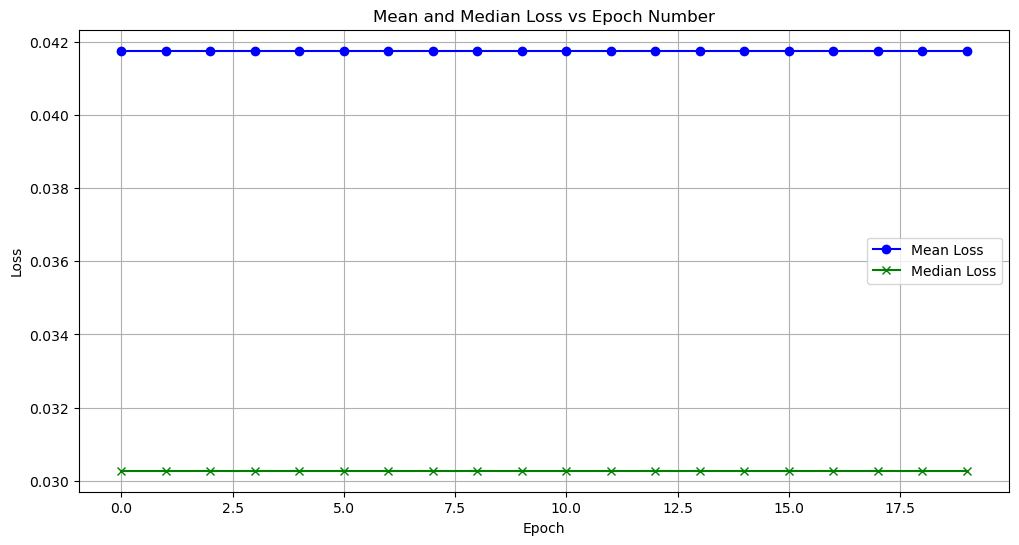

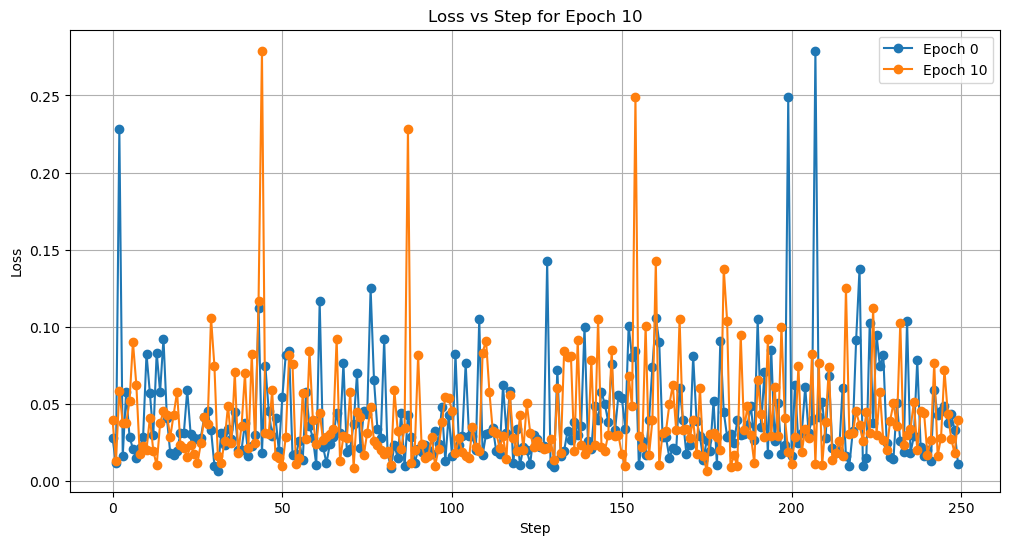

In [30]:
# Plot mean average loss vs epoch number
plt.figure(figsize=(12, 6))
plt.plot(df['Epoch'], df['Mean Loss'], label='Mean Loss', marker='o', color='blue')
plt.plot(df['Epoch'], df['Median Loss'], label='Median Loss', marker='x', color='green')
plt.title('Mean and Median Loss vs Epoch Number')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))


# Plot loss vs step for each epoch

for index in range(0, len(log_files), 10):
    log_file = log_files[index]
    # print(log_file)
    epoch_number = int(log_file.split('_')[-1].split('.')[0])
    
    with open(os.path.join(log_dir, log_file), 'r') as file:
        data = json.load(file)
        steps = [step['step'] for step in data['steps']]
        losses = [step['test_loss'] for step in data['steps']]    
    plt.plot(steps, losses, label=f'Epoch {epoch_number}', marker='o')
plt.title(f'Loss vs Step for Epoch {epoch_number}')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# # Plot loss vs step for each epoch
# for log_file in log_files:
#     epoch_number = int(log_file.split('_')[-1].split('.')[0])
    
#     with open(os.path.join(log_dir, log_file), 'r') as file:
#         data = json.load(file)
#         steps = [step['step'] for step in data['steps']]
#         losses = [step['test_loss'] for step in data['steps']]
    
#     plt.figure(figsize=(12, 6))
#     plt.plot(steps, losses, label=f'Epoch {epoch_number}', marker='o')
#     plt.title(f'Loss vs Step for Epoch {epoch_number}')
#     plt.xlabel('Step')
#     plt.ylabel('Loss')
#     plt.grid(True)
#     plt.show()




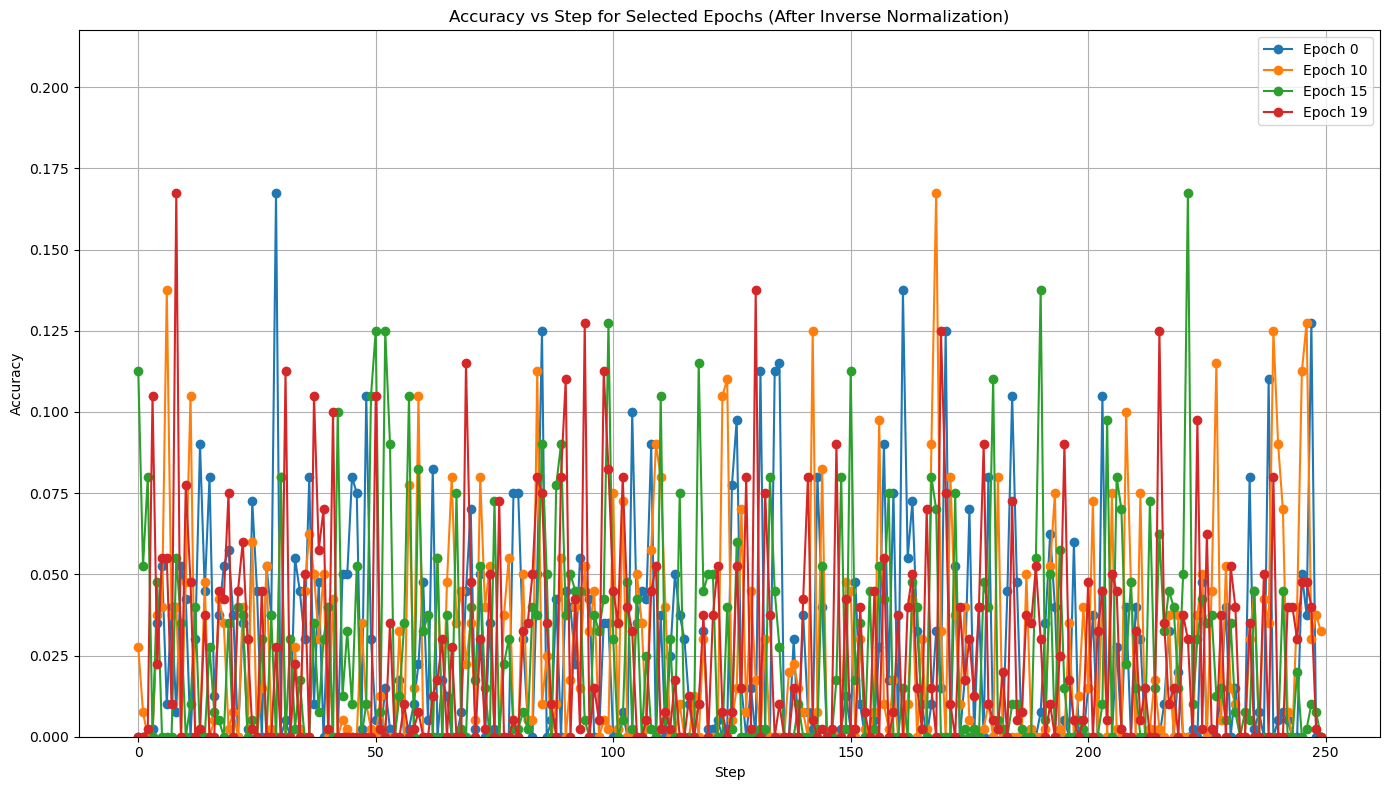

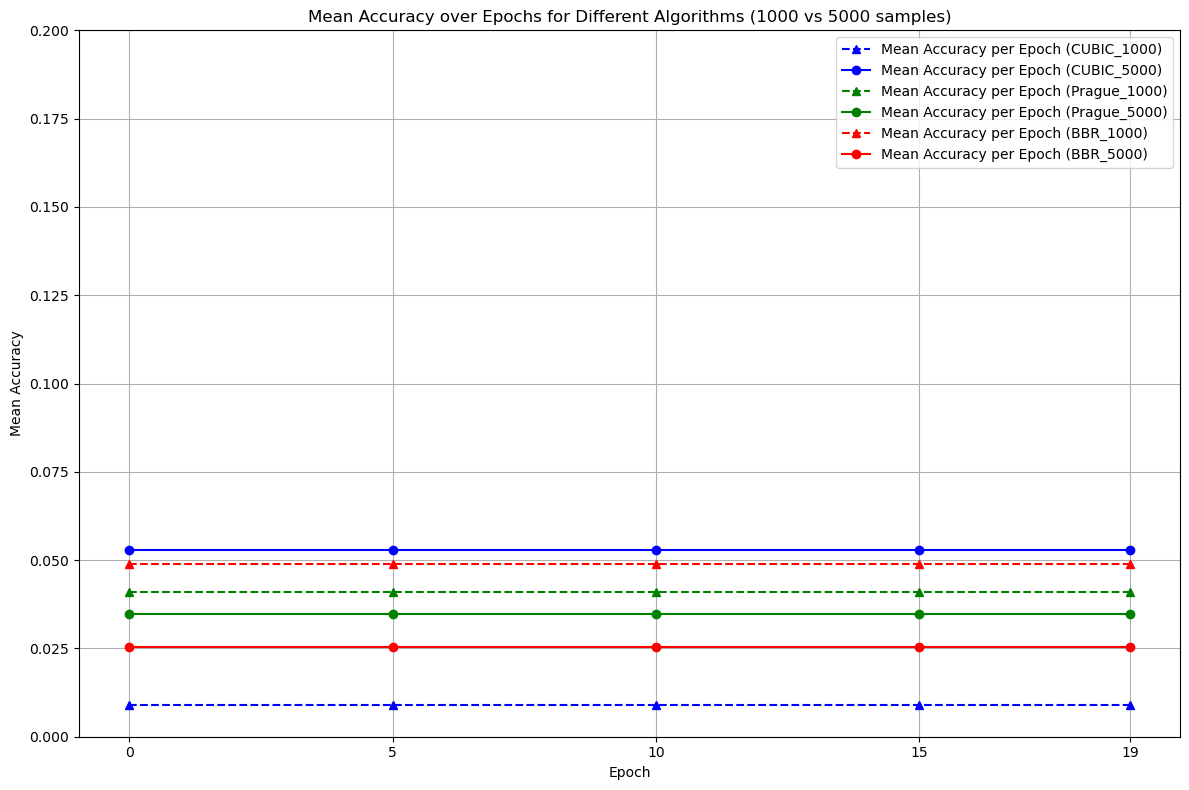

In [31]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Directory containing the log files (update this path as needed)
log_dir = r'D:\LLM-CCA testing\test data\5000BBR'
csv_file_path = r'C:\Users\10111\Desktop\SIT724\Runpod\experiment data\通过脚本或取得prague和cubic的数据\cubic & bbr & prague\bbr_output_rtt_cwnd_throughput.csv'

# 读取CSV文件以获得最大值和最小值
df = pd.read_csv(csv_file_path)
max_cwnd_value = df['cwnd'].max()
min_cwnd_value = df['cwnd'].min()

# 选择要绘制的epochs
selected_epochs = [0, 10, 15, 19]  # 可根据需要修改
metrics = {
    'steps': [],
    'accuracies': {}
}

# 读取所有 custom_logs_epoch_test_*.json 文件
log_files = [f for f in os.listdir(log_dir) if f.startswith('custom_logs_epoch_test_') and f.endswith('.json')]
log_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

# 定义逆归一化函数
def inverse_normalize(normalized_value, min_value, max_value):
    if isinstance(normalized_value, (list, np.ndarray)):  # 检查是否为列表或数组
        return [inverse_normalize(val, min_value, max_value) for val in normalized_value]
    else:
        return normalized_value * (max_value - min_value) + min_value

# 循环遍历每个日志文件，以提取所选epochs的准确度数据
for log_file in log_files:
    epoch_number = int(log_file.split('_')[-1].split('.')[0])
    
    if epoch_number in selected_epochs:
        with open(os.path.join(log_dir, log_file), 'r') as file:
            data = json.load(file)
            steps = [step['step'] for step in data['steps']]
            actions_preds = [step['actions_pred'] for step in data['steps']]
            actions = [step['actions'] for step in data['steps']]
            
            # 如果还没有存储步数，则进行存储
            if not metrics['steps']:
                metrics['steps'] = steps
            
            # 使用逆归一化的方法计算每个步骤的准确度
            accuracies = []
            for preds, true_actions in zip(actions_preds, actions):
                # 将预测值和实际值转换为一维数值列表形式，以便于逆归一化
                preds_array = np.array(inverse_normalize(preds, min_cwnd_value, max_cwnd_value))
                true_actions_array = np.array(inverse_normalize(true_actions, min_cwnd_value, max_cwnd_value))

                # 计算相对误差并与固定的5%容差进行比较
                relative_error = np.abs(preds_array - true_actions_array) / np.abs(true_actions_array)
                accuracy = np.mean(relative_error < 0.05)  # 允许的相对误差为5%
                accuracies.append(accuracy)
            
            # 存储当前epoch的准确度
            metrics['accuracies'][epoch_number] = accuracies

# 动态调整y轴范围以适应数据
all_accuracies = [acc for epoch in selected_epochs for acc in metrics['accuracies'].get(epoch, [])]
min_accuracy = max(0, min(all_accuracies) - 0.05)  # 在最小值下方增加一些缓冲
max_accuracy = min(1, max(all_accuracies) + 0.05)  # 在最大值上方增加一些缓冲

# 绘制图表
plt.figure(figsize=(14, 8))

# 为每个选择的epoch绘制Accuracy vs Step图表
for epoch in selected_epochs:
    if epoch in metrics['accuracies']:
        plt.plot(metrics['steps'], metrics['accuracies'][epoch], marker='o', label=f'Epoch {epoch}')

plt.title('Accuracy vs Step for Selected Epochs (After Inverse Normalization)')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.ylim(min_accuracy, max_accuracy)  # 动态调整y轴范围以适应数据
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Directories containing the log files and CSV paths for different algorithms
config = {
    'CUBIC_1000': {
        'log_dir': r'D:\LLM-CCA testing\test data\1000CUBIC',
        'csv_file_path': r'C:\Users\10111\Desktop\SIT724\Runpod\experiment data\通过脚本或取得prague和cubic的数据\cubic & bbr & prague\cubic_output_rtt_cwnd_throughput.csv',
        'line_style': '--',  # 虚线表示1000样本
        'marker': '^',  # 三角形标记
        'color': 'blue'  # 使用蓝色表示CUBIC
    },
    'CUBIC_5000': {
        'log_dir': r'D:\LLM-CCA testing\test data\5000CUBIC',
        'csv_file_path': r'C:\Users\10111\Desktop\SIT724\Runpod\experiment data\通过脚本或取得prague和cubic的数据\cubic & bbr & prague\cubic_output_rtt_cwnd_throughput.csv',
        'line_style': '-',  # 实线表示5000样本
        'marker': 'o',  # 圆形标记
        'color': 'blue'
    },
    'Prague_1000': {
        'log_dir': r'D:\LLM-CCA testing\test data\1000PRAGUE',
        'csv_file_path': r'C:\Users\10111\Desktop\SIT724\Runpod\experiment data\通过脚本或取得prague和cubic的数据\cubic & bbr & prague\prague_output_rtt_cwnd_throughput.csv',
        'line_style': '--',
        'marker': '^',
        'color': 'green'  # 使用绿色表示Prague
    },
    'Prague_5000': {
        'log_dir': r'D:\LLM-CCA testing\test data\5000PRAGUE',
        'csv_file_path': r'C:\Users\10111\Desktop\SIT724\Runpod\experiment data\通过脚本或取得prague和cubic的数据\cubic & bbr & prague\prague_output_rtt_cwnd_throughput.csv',
        'line_style': '-',
        'marker': 'o',
        'color': 'green'
    },
    'BBR_1000': {
        'log_dir': r'D:\LLM-CCA testing\test data\1000BBR',
        'csv_file_path': r'C:\Users\10111\Desktop\SIT724\Runpod\experiment data\通过脚本或取得prague和cubic的数据\cubic & bbr & prague\bbr_output_rtt_cwnd_throughput.csv',
        'line_style': '--',
        'marker': '^',
        'color': 'red'  # 使用红色表示BBR
    },
    'BBR_5000': {
        'log_dir': r'D:\LLM-CCA testing\test data\5000BBR',
        'csv_file_path': r'C:\Users\10111\Desktop\SIT724\Runpod\experiment data\通过脚本或取得prague和cubic的数据\cubic & bbr & prague\bbr_output_rtt_cwnd_throughput.csv',
        'line_style': '-',
        'marker': 'o',
        'color': 'red'
    }
}

# Select epochs to plot
selected_epochs = [0, 5, 10, 15, 19]

# Initialize a dictionary to store mean accuracies for each algorithm
all_metrics = {}

# Loop through each configuration for different algorithms
for algo_name, algo_config in config.items():
    log_dir = algo_config['log_dir']
    csv_file_path = algo_config['csv_file_path']

    # Read the CSV file to get min and max CWND values for inverse normalization
    df = pd.read_csv(csv_file_path)
    max_cwnd_value = df['cwnd'].max()
    min_cwnd_value = df['cwnd'].min()

    # Function to inverse normalize CWND values
    def inverse_normalize(normalized_value, min_value, max_value):
        return normalized_value * (max_value - min_value) + min_value

    metrics = {
        'steps': [],
        'mean_accuracies': {},  # Dictionary to store mean accuracy for each epoch
        'accuracies': {}
    }

    # Read all the custom_logs_epoch_test_*.json files
    log_files = [f for f in os.listdir(log_dir) if f.startswith('custom_logs_epoch_test_') and f.endswith('.json')]
    log_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

    # Loop through each log file to extract accuracy data for selected epochs
    for log_file in log_files:
        epoch_number = int(log_file.split('_')[-1].split('.')[0])
        
        if epoch_number in selected_epochs:
            with open(os.path.join(log_dir, log_file), 'r') as file:
                data = json.load(file)
                steps = [step['step'] for step in data['steps']]
                actions_preds = [step['actions_pred'] for step in data['steps']]
                actions = [step['actions'] for step in data['steps']]
                
                # Store steps for plotting (assuming they are consistent across selected epochs)
                if not metrics['steps']:
                    metrics['steps'] = steps
                
                # Flatten the lists further to ensure all elements are individual numbers
                def flatten_list(nested_list):
                    """Flattens a nested list to a single level."""
                    flat_list = []
                    for item in nested_list:
                        if isinstance(item, list):
                            flat_list.extend(flatten_list(item))
                        else:
                            flat_list.append(item)
                    return flat_list

                # Calculate accuracy for each step using inverse normalized values
                accuracies = []
                for preds, true_actions in zip(actions_preds, actions):
                    preds_flat = flatten_list(preds)
                    true_actions_flat = flatten_list(true_actions)

                    preds_array = np.array([inverse_normalize(float(p), min_cwnd_value, max_cwnd_value) for p in preds_flat])
                    true_actions_array = np.array([inverse_normalize(float(t), min_cwnd_value, max_cwnd_value) for t in true_actions_flat])

                    relative_error = np.abs(preds_array - true_actions_array) / np.abs(true_actions_array)
                    accuracy = np.mean(relative_error < 0.05)
                    accuracies.append(accuracy)
                
                metrics['accuracies'][epoch_number] = accuracies
                mean_accuracy = np.mean(accuracies) if accuracies else 0
                metrics['mean_accuracies'][epoch_number] = mean_accuracy
                # print(f"{algo_name} - Epoch {epoch_number}: Mean Accuracy = {mean_accuracy:.4f}")

    all_metrics[algo_name] = metrics

# Plotting Mean Accuracy over Epochs for each algorithm
plt.figure(figsize=(12, 8))

# Plot the mean accuracy for each selected epoch for all algorithms
for algo_name, metrics in all_metrics.items():
    epochs = list(metrics['mean_accuracies'].keys())
    mean_accuracies = [metrics['mean_accuracies'][epoch] for epoch in epochs]
    plt.plot(epochs, mean_accuracies, marker=config[algo_name]['marker'], linestyle=config[algo_name]['line_style'], color=config[algo_name]['color'], label=f'Mean Accuracy per Epoch ({algo_name})')

plt.title('Mean Accuracy over Epochs for Different Algorithms (1000 vs 5000 samples)')
plt.xlabel('Epoch')
plt.ylabel('Mean Accuracy')
plt.ylim(0, 0.2)  # 设置 y 轴范围为 0 到 0.2
plt.xticks(selected_epochs)  # Show each selected epoch on the x-axis
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()



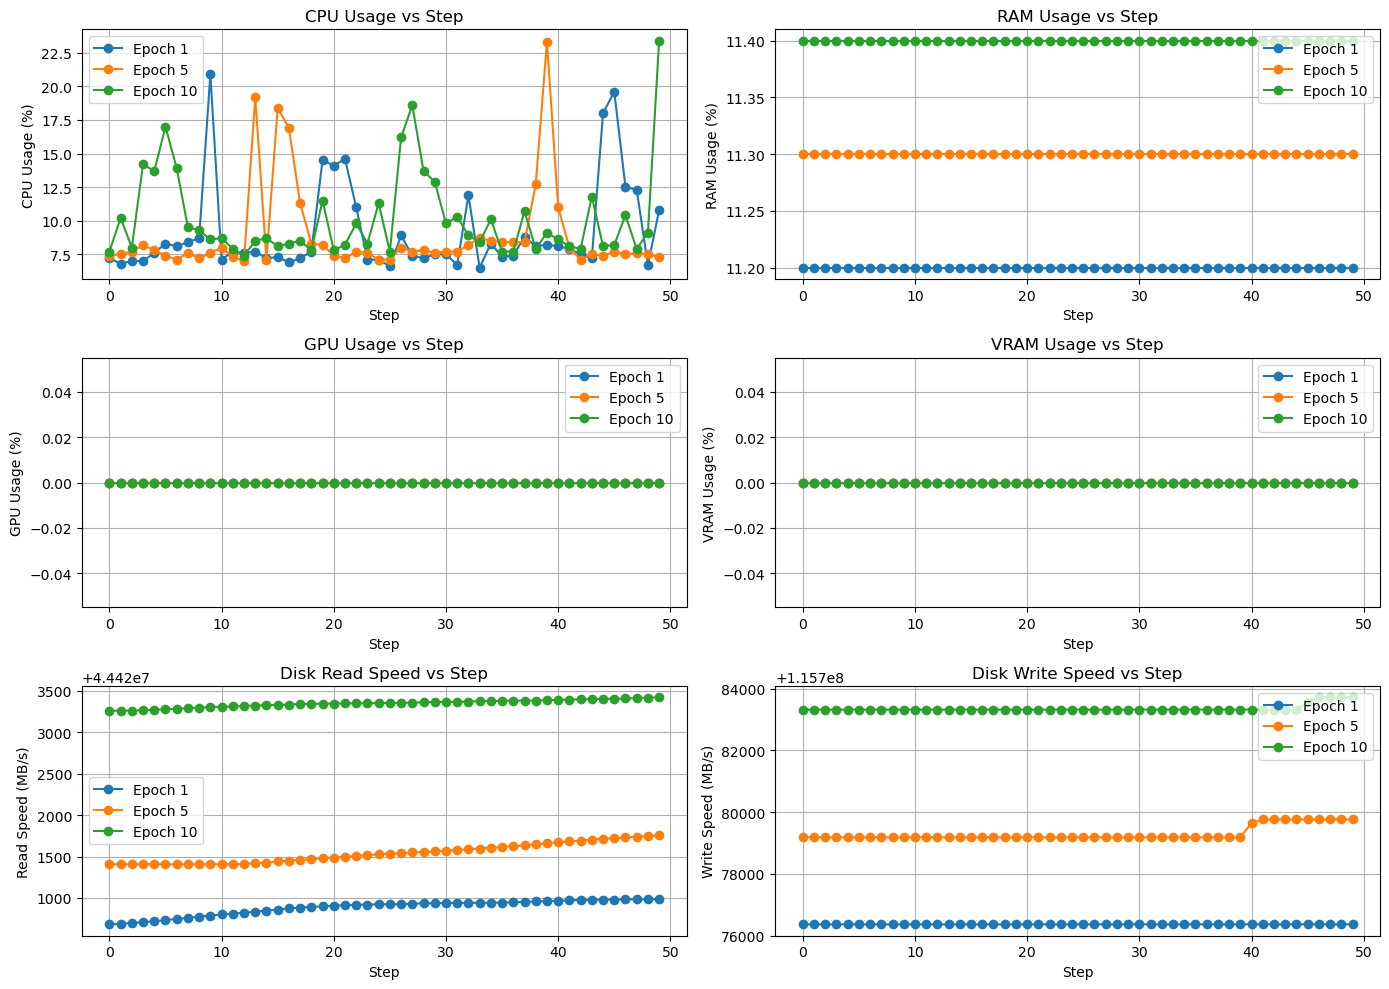

In [32]:
import os
import json
import matplotlib.pyplot as plt

# Directory containing the log files (update this path as needed)
log_dir = r'D:\LLM-CCA testing\test data\1000BBR'

# Read all the custom_logs_epoch_test_*.json files
log_files = [f for f in os.listdir(log_dir) if f.startswith('custom_logs_epoch_test_') and f.endswith('.json')]
log_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

# Initialize lists for storing metrics
selected_epochs = [1, 5, 10]  # Add more as needed
metrics = {
    'steps': [],
    'cpu_usages': {},
    'ram_usages': {},
    'gpu_usages': {},
    'vram_usages': {},
    'disk_read_speeds': {},
    'disk_write_speeds': {}
}

# Loop through the log files to extract metrics for selected epochs
for log_file in log_files:
    epoch_number = int(log_file.split('_')[-1].split('.')[0])

    if epoch_number in selected_epochs:
        with open(os.path.join(log_dir, log_file), 'r') as file:
            data = json.load(file)
            steps = [step['step'] for step in data['steps']]
            cpu_usages = [step.get('CPU Usage', 0) for step in data['steps']]
            ram_usages = [step.get('RAM Usage', 0) for step in data['steps']]
            gpu_usages = [step.get('GPU Usage', 0) for step in data['steps']]
            vram_usages = [step.get('VRAM Usage', 0) for step in data['steps']]
            disk_read_speeds = [step.get('Disk Read Speed (MB/s)', 0) for step in data['steps']]
            disk_write_speeds = [step.get('Disk Write Speed (MB/s)', 0) for step in data['steps']]

            # Store metrics by epoch number
            metrics['steps'] = steps  # Assuming steps are the same for each selected epoch
            metrics['cpu_usages'][epoch_number] = cpu_usages
            metrics['ram_usages'][epoch_number] = ram_usages
            metrics['gpu_usages'][epoch_number] = gpu_usages
            metrics['vram_usages'][epoch_number] = vram_usages
            metrics['disk_read_speeds'][epoch_number] = disk_read_speeds
            metrics['disk_write_speeds'][epoch_number] = disk_write_speeds

# Plotting
plt.figure(figsize=(14, 10))

# Plot CPU Usage
plt.subplot(3, 2, 1)
for epoch in selected_epochs:
    plt.plot(metrics['steps'], metrics['cpu_usages'][epoch], label=f'Epoch {epoch}', marker='o')
plt.title('CPU Usage vs Step')
plt.xlabel('Step')
plt.ylabel('CPU Usage (%)')
plt.legend()
plt.grid()

# Plot RAM Usage
plt.subplot(3, 2, 2)
for epoch in selected_epochs:
    plt.plot(metrics['steps'], metrics['ram_usages'][epoch], label=f'Epoch {epoch}', marker='o')
plt.title('RAM Usage vs Step')
plt.xlabel('Step')
plt.ylabel('RAM Usage (%)')
plt.legend()
plt.grid()

# Plot GPU Usage
plt.subplot(3, 2, 3)
for epoch in selected_epochs:
    plt.plot(metrics['steps'], metrics['gpu_usages'][epoch], label=f'Epoch {epoch}', marker='o')
plt.title('GPU Usage vs Step')
plt.xlabel('Step')
plt.ylabel('GPU Usage (%)')
plt.legend()
plt.grid()

# Plot VRAM Usage
plt.subplot(3, 2, 4)
for epoch in selected_epochs:
    plt.plot(metrics['steps'], metrics['vram_usages'][epoch], label=f'Epoch {epoch}', marker='o')
plt.title('VRAM Usage vs Step')
plt.xlabel('Step')
plt.ylabel('VRAM Usage (%)')
plt.legend()
plt.grid()

# Plot Disk Read Speed
plt.subplot(3, 2, 5)
for epoch in selected_epochs:
    plt.plot(metrics['steps'], metrics['disk_read_speeds'][epoch], label=f'Epoch {epoch}', marker='o')
plt.title('Disk Read Speed vs Step')
plt.xlabel('Step')
plt.ylabel('Read Speed (MB/s)')
plt.legend()
plt.grid()

# Plot Disk Write Speed
plt.subplot(3, 2, 6)
for epoch in selected_epochs:
    plt.plot(metrics['steps'], metrics['disk_write_speeds'][epoch], label=f'Epoch {epoch}', marker='o')
plt.title('Disk Write Speed vs Step')
plt.xlabel('Step')
plt.ylabel('Write Speed (MB/s)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()



### Plot Returns for each epoch

In [33]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Assuming you've already imported required libraries and set up your data as before

# # Read and extract returns for each epoch
# epoch_returns = {}

# # Loop through each log file and extract returns along with the epoch
# for log_file in log_files:
#     epoch_number = int(log_file.split('_')[-1].split('.')[0])
    
#     with open(os.path.join(log_dir, log_file), 'r') as file:
#         data = json.load(file)
        
#         returns = np.array([step['returns'] for step in data['steps']])
#         # Reshape returns if necessary
#         returns = returns.flatten()

#         # print(np.mean(returns))
        
#         # Store returns for the current epoch
#         epoch_returns[epoch_number] = returns

# # Plot returns vs steps for each epoch in separate graphs
# for epoch_number, returns in epoch_returns.items():
#     plt.figure(figsize=(10, 5))
#     steps = np.arange(len(returns))  # Create an array for step numbers
#     plt.plot(steps, returns, marker='o', label=f'Epoch {epoch_number}')
    
#     plt.title(f'Returns vs Steps for Epoch {epoch_number}')
#     plt.xlabel('Step Number')
#     plt.ylabel('Returns')
#     plt.grid(True)
#     plt.legend()
    
#     # Show each plot
#     plt.show()

# # Set the figure size
# plt.figure(figsize=(12, 6))

# # Plot Mean Return
# plt.subplot(1, 2, 1)
# plt.plot(df['Epoch'], df['Mean Return'], marker='o', color='blue', label='Mean Return')
# plt.title('Mean Return vs Epoch Number')
# plt.xlabel('Epoch Number')
# plt.ylabel('Mean Return')
# plt.grid(True)
# plt.legend()

# # Plot Median Return
# plt.subplot(1, 2, 2)
# plt.plot(df['Epoch'], df['Median Return'], marker='o', color='orange', label='Median Return')
# plt.title('Median Return vs Epoch Number')
# plt.xlabel('Epoch Number')
# plt.ylabel('Median Return')
# plt.grid(True)
# plt.legend()

# # Show the plots
# plt.tight_layout()
# plt.show()
